# DATA 608 - Module 2
John Mazon

September 26, 2021

In [8]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy

In [9]:
from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

In [10]:
# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

In [11]:
from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from here. Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.


In [17]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 4A16-B088

 Directory of C:\Users\pc\Desktop\module2

09/26/2021  08:37 PM    <DIR>          .
09/26/2021  08:37 PM    <DIR>          ..
09/26/2021  08:31 PM    <DIR>          .ipynb_checkpoints
08/25/2021  04:22 PM                 5 MapPLUTO.CPG
08/25/2021  04:22 PM     1,002,076,792 MapPLUTO.dbf
08/25/2021  04:15 PM               562 MapPLUTO.prj
08/25/2021  04:23 PM         7,493,940 MapPLUTO.sbn
08/25/2021  04:23 PM           112,092 MapPLUTO.sbx
08/25/2021  04:22 PM       137,494,260 MapPLUTO.shp
08/26/2021  02:02 PM           130,656 MapPLUTO.shp.xml
08/25/2021  04:22 PM         6,857,748 MapPLUTO.shx
08/26/2021  02:09 PM    <DIR>          MapPLUTO_21v2.gdb
06/25/2021  04:33 PM                 5 MapPLUTO_UNCLIPPED.cpg
06/25/2021  04:33 PM       959,455,958 MapPLUTO_UNCLIPPED.dbf
06/25/2021  04:21 PM               562 MapPLUTO_UNCLIPPED.prj
06/25/2021  04:26 PM         7,495,292 MapPLUTO_UNCLIPPED.sbn
06/25/2021  04:26 PM  

In [19]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv(r'pluto_21v2.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

C:\Users\pc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (19,20,22,24,26,63,64) have mixed types.Specify dtype option on import or set low_memory=False.





I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.


In [20]:
# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation


Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps.

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [21]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '33ec08f3-c5ea-4a3d-b43e-0716bac8e6ff',
 …

Something looks off... You're going to have to deal with this imperfect data to answer this first question.

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

Hello all, here are some pandas tips to help you guys through this homework:

Indexing and Selecting: .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

Group By: This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a reset_index().

Reset_index: I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a huge section on datetime indexing. In particular, check out resample, which provides time series specific aggregation.

Merging, joining, and concatenation: There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.


## Question
After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [43]:
# let's explore the data!
# it's always a good idea to start with head
ny.head()

borough  block   lot     cd  ct2010  cb2010  schooldist  council  zipcode  \
1      MN    445    54  103.0   38.00  4000.0         1.0      2.0  10003.0   
2      MN    467    55  103.0   40.00  2000.0         1.0      2.0  10003.0   
3      BK   2621  7501  301.0  573.00  3003.0        14.0     33.0  11222.0   
4      MN   1970    58  109.0  213.03  1001.0         5.0      9.0  10027.0   
5      BX   2646     7  201.0   77.00  1011.0         7.0     17.0  10456.0   

  firecomp  ...  plutomapid  firm07_flag  pfirm15_flag  version  dcpedited  \
1     E028  ...           1          NaN           NaN     21v2        NaN   
2     L003  ...           1          NaN           NaN     21v2        NaN   
3     E238  ...           1          NaN           NaN     21v2        NaN   
4     E080  ...           1          NaN           NaN     21v2        NaN   
5     E073  ...           1          NaN           NaN     21v2        NaN   

    latitude  longitude notes floor_bins decade  
1  40.725333 -73.988711   NaN        1-9   1990  
2  40.731190 -73.987722   NaN        1-9   1920  
3  40.726484 -73.951001   NaN        1-9   2000  
4  40.817053 -73.952741   NaN        1-9   1900  
5  40.819006 -73.906469   NaN        1-9   1910  

[5 rows x 92 columns]

In [58]:
# additionally I always like to see tail
ny.tail()

borough  block  lot     cd  ct2010  cb2010  schooldist  council  \
858116      SI    301   17  501.0  121.00  2010.0        31.0     49.0   
858119      SI    275   63  501.0  121.00  3001.0        31.0     49.0   
858134      SI   1703   75  501.0  303.02  4007.0        31.0     49.0   
858152      SI   2835   48  501.0    6.00     NaN        31.0     49.0   
858187      SI   5266   11  503.0  156.01  5003.0        31.0     51.0   

        zipcode firecomp  ...  plutomapid  firm07_flag  pfirm15_flag  version  \
858116  10310.0     E156  ...           1          NaN           NaN     21v2   
858119  10310.0     E156  ...           1          NaN           NaN     21v2   
858134  10303.0     E166  ...           1          NaN           NaN     21v2   
858152  10305.0     E152  ...           1          NaN           NaN     21v2   
858187  10312.0     L082  ...           1          NaN           NaN     21v2   

        dcpedited   latitude  longitude notes floor_bins decade  
858116        NaN  40.626050 -74.112072   NaN        1-9   1980  
858119        NaN  40.629997 -74.106084   NaN        1-9   1940  
858134        NaN  40.623862 -74.152213   NaN        1-9   1970  
858152        NaN  40.610597 -74.059960   NaN        1-9   1910  
858187        NaN  40.541165 -74.157789   NaN        1-9   1960  

[5 rows x 92 columns]

In [63]:
# always a good idea to learn our columns and view what data we can use
print(ny.columns)

Index(['borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist',
       'council', 'zipcode', 'firecomp', 'policeprct', 'healthcenterdistrict',
       'healtharea', 'sanitboro', 'sanitdistrict', 'sanitsub', 'address',
       'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1',
       'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone',
       'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername',
       'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource',
       'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',
       'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode',
       'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot',
       'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark',
       'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl',
       'condono', 'tract2010', 'xcoo

In [ ]:
# The describe() method will do a quick statistical summary for every numerical column

In [59]:
ny.describe()

block            lot             cd         ct2010  \
count  810654.000000  810654.000000  810541.000000  810541.000000   
mean     5332.173450     136.035538     355.141858     466.293900   
std      3671.927044     762.785059      99.569591     377.245006   
min         1.000000       1.000000     101.000000       1.000000   
25%      2370.000000      19.000000     307.000000     170.070000   
50%      4871.000000      38.000000     402.000000     358.000000   
75%      7515.000000      64.000000     412.000000     664.000000   
max     16350.000000    9450.000000     595.000000    1621.000000   

              cb2010     schooldist        council        zipcode  \
count  808795.000000  810541.000000  810541.000000  810533.000000   
mean     2056.063707      22.117466      32.143442   11020.126641   
std      1153.058069       7.889717      13.146215     466.817824   
min         1.000000       1.000000       1.000000   10001.000000   
25%      1004.000000      17.000000      23.000000   10466.000000   
50%      2001.000000      24.000000      32.000000   11222.000000   
75%      3000.000000      29.000000      44.000000   11370.000000   
max      9003.000000      32.000000      51.000000   12345.000000   

          policeprct  healthcenterdistrict  ...        xcoord         ycoord  \
count  810541.000000         810541.000000  ...  8.105800e+05  810580.000000   
mean       87.185375             38.352801  ...  1.006350e+06  191354.644764   
std        29.085216              9.508277  ...  3.254835e+04   30508.470637   
min         1.000000             11.000000  ...  9.131640e+05  120966.000000   
25%        66.000000             33.000000  ...  9.896700e+05  168060.000000   
50%       102.000000             41.000000  ...  1.009032e+06  189088.000000   
75%       111.000000             45.000000  ...  1.029533e+06  210836.000000   
max       123.000000             51.000000  ...  1.067279e+06  272275.000000   

              taxmap        appbbl     plutomapid  firm07_flag  pfirm15_flag  \
count  810538.000000  8.691700e+04  810654.000000      26320.0       55690.0   
mean    36770.860162  3.755011e+09       1.000099          1.0           1.0   
std     10722.255987  1.215467e+09       0.009934          0.0           0.0   
min         1.000000  1.000020e+09       1.000000          1.0           1.0   
25%     31106.000000  3.024390e+09       1.000000          1.0           1.0   
50%     40602.000000  4.050180e+09       1.000000          1.0           1.0   
75%     44602.000000  5.023700e+09       1.000000          1.0           1.0   
max     53203.000000  5.080490e+09       2.000000          1.0           1.0   

            latitude      longitude  notes  
count  810580.000000  810580.000000    0.0  
mean       40.691813     -73.920220    NaN  
std         0.083729       0.117334    NaN  
min        40.498445     -74.255628    NaN  
25%        40.627937     -73.980461    NaN  
50%        40.685592     -73.910610    NaN  
75%        40.745257     -73.836557    NaN  
max        40.913967     -73.700381    NaN  

[8 rows x 62 columns]

In [60]:
# without a doubt one of the most "hottest" topics in DS is find null info
ny.isnull()

borough  block    lot     cd  ct2010  cb2010  schooldist  council  \
1         False  False  False  False   False   False       False    False   
2         False  False  False  False   False   False       False    False   
3         False  False  False  False   False   False       False    False   
4         False  False  False  False   False   False       False    False   
5         False  False  False  False   False   False       False    False   
...         ...    ...    ...    ...     ...     ...         ...      ...   
858116    False  False  False  False   False   False       False    False   
858119    False  False  False  False   False   False       False    False   
858134    False  False  False  False   False   False       False    False   
858152    False  False  False  False   False    True       False    False   
858187    False  False  False  False   False   False       False    False   

        zipcode  firecomp  ...  plutomapid  firm07_flag  pfirm15_flag  \
1         False     False  ...       False         True          True   
2         False     False  ...       False         True          True   
3         False     False  ...       False         True          True   
4         False     False  ...       False         True          True   
5         False     False  ...       False         True          True   
...         ...       ...  ...         ...          ...           ...   
858116    False     False  ...       False         True          True   
858119    False     False  ...       False         True          True   
858134    False     False  ...       False         True          True   
858152    False     False  ...       False         True          True   
858187    False     False  ...       False         True          True   

        version  dcpedited  latitude  longitude  notes  floor_bins  decade  
1         False       True     False      False   True       False   False  
2         False       True     False      False   True       False   False  
3         False       True     False      False   True       False   False  
4         False       True     False      False   True       False   False  
5         False       True     False      False   True       False   False  
...         ...        ...       ...        ...    ...         ...     ...  
858116    False       True     False      False   True       False   False  
858119    False       True     False      False   True       False   False  
858134    False       True     False      False   True       False   False  
858152    False       True     False      False   True       False   False  
858187    False       True     False      False   True       False   False  

[810654 rows x 92 columns]

In [62]:
# here we view some specifics to better understand our data
ny['borough'].value_counts()

QN    311295
BK    263555
SI    114537
BX     82780
MN     38487
Name: borough, dtype: int64

In [ ]:
ny['borough'].value_counts()

I'm curious to find a few relevant stats from our data. This might include max/min of bldg depth, floors, etc  

In [54]:
ny['bldgdepth'].max()

9388.0

In [55]:
ny['bldgdepth'].min()

0.0

In [56]:
ny['numfloors'].max()

104.0

In [57]:
ny['numfloors'].min()

0.1

In [64]:
#the first step is to “bin” the range of values — that is, divide the entire range of values into a series of intervals — and then count how many values fall into each interval. The bins are usually specified as consecutive, non-overlapping intervals of a variable. The bins (intervals) must be adjacent and are often (but are not required to be) of equal size.

bins = [0, 9, 19, 29, 39, 49, 110]
floor_labels = ['1-9','10-19','20-29','30-39','40-49','50-110']


ny['floor_bins'] = pd.cut(ny['numfloors'], bins=bins, labels=floor_labels)
print (ny.groupby(['floor_bins']).size())



floor_bins
1-9       804223
10-19       4517
20-29       1092
30-39        465
40-49        226
50-110       131
dtype: int64


In [28]:
# A Pandas Series is like a column in a table.
# It is a one-dimensional array holding data of any type.

decade_labels = pd.Series(np.arange(1850,2020,10))
ny['decade'] = pd.cut(ny['yearbuilt'], bins=pd.Series(np.arange(1849,2029,10)), labels=decade_labels)
ny[['yearbuilt','decade','floor_bins']].head()

yearbuilt decade floor_bins
1     1999.0   1990        1-9
2     1920.0   1920        1-9
3     2007.0   2000        1-9
4     1901.0   1900        1-9
5     1910.0   1910        1-9

In [29]:
#Pandas groupby is used for grouping the data according to the categories and apply a function to the categories. It also helps to aggregate data efficiently.
#Pandas dataframe.groupby() function is used to split the data into groups based on some criteria. pandas objects can be split on any of their axes. The abstract definition of grouping is to provide a mapping of labels to group names.

ny_group = ny.groupby(['decade', 'floor_bins']).size().reset_index(name='count')

ny_group.head()

decade floor_bins  count
0   1850        1-9   1552
1   1850      10-19      1
2   1850      20-29      0
3   1850      30-39      0
4   1850      40-49      0

In [30]:
ny_group.drop(ny_group.loc[ny_group['count']==0].index, inplace=True)

ny_group['count_base10'] = np.log10(ny_group['count'])

# with ordering our final chart displays the floor bins in numerical order.
ny_group.sort_values('floor_bins', inplace=True)

ny_group.head()

decade floor_bins  count  count_base10
0    1850        1-9   1552      3.190892
96   2010        1-9  14737      4.168409
90   2000        1-9  42445      4.627827
84   1990        1-9  28781      4.459106
78   1980        1-9  26825      4.428540

In [71]:
#Plotly Express is a high-level wrapper for Plotly, which essentially means it does a lot of the things that you can do it Plotly with a much simpler syntax. ... After Plotly Express is installed, a simple import plotly_express as px is all you need to start creating simple, interactive visualizations with Python

import plotly.express as px


fig_ny = px.bar(ny_group, x="decade", y="count_base10", color="floor_bins",
               color_discrete_sequence=px.colors.qualitative.Antique,
               height=700,
               title="Buildings in New York City (By Decade)",
               labels={
                  "decade": "Decade",
                  "count_base10": "Log Base 10 of Count",
                  "floor_bins": "Floors"
               })

# ordering our legend
fig_ny.update_layout(legend_traceorder="reversed")
fig_ny.show()

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [75]:
fig = go.FigureWidget(
    data = [
        go.Histogram2d(x=ny['yearbuilt'], y=ny['numfloors'], autobiny=False, ybins={'size': 1}, colorscale='Electric')
    ]
)

fig

FigureWidget({
    'data': [{'autobiny': False,
              'colorscale': [[0.0, 'rgb(0,0,0)'], [0.2, 'rgb(3…


This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook Plotting Perils.

Here is what the same plot would look like in datashader:


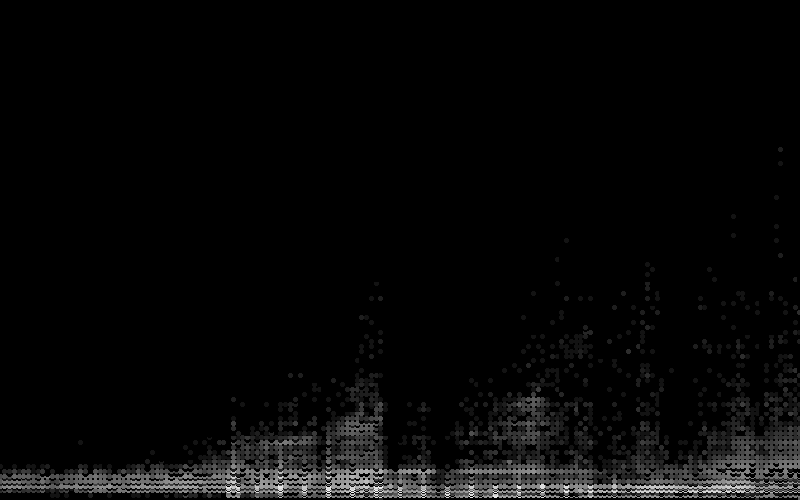

In [23]:
#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')



That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:


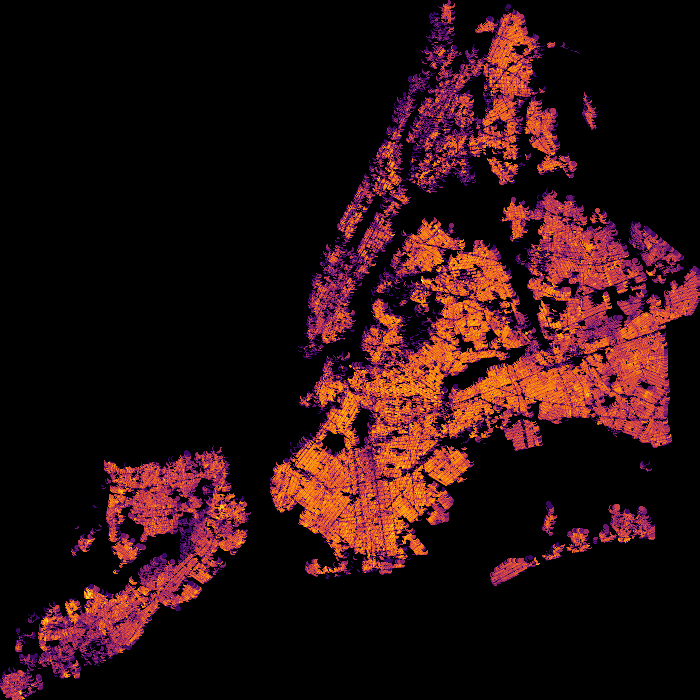

In [24]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

## Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

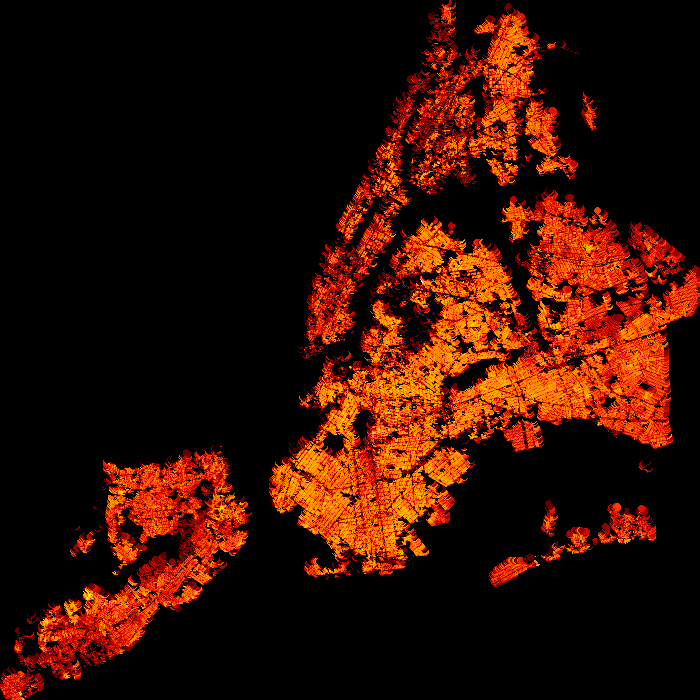

In [93]:
import datashader as ds, pandas as pd, colorcet
NYC   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NYC)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap=colorcet.fire, how='log')
export(tf.spread(view, px=3), 'firery')

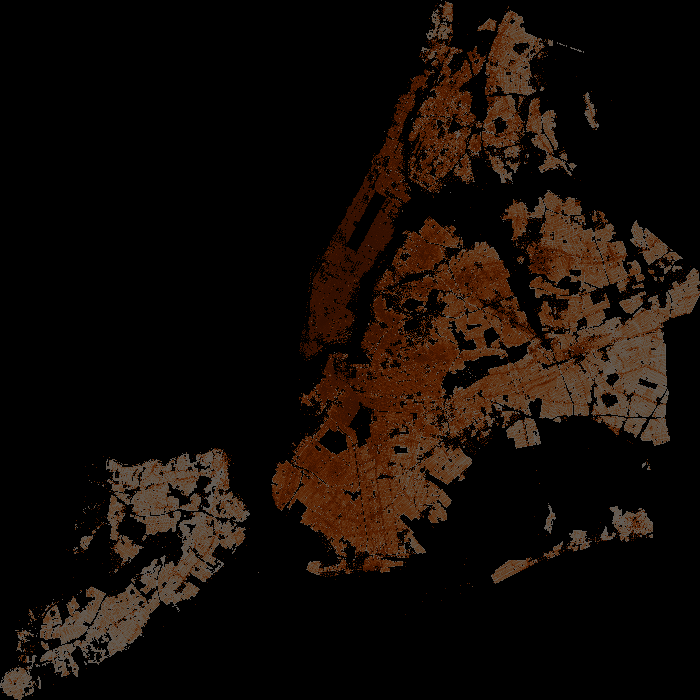

In [98]:
from matplotlib import cm as mcm 

cvs = ds.Canvas(700, 700, *NYC)
agg = cvs.points(ny, 'xcoord', 'ycoord', ds.sum('assesstot'))
img1 = tf.shade(agg, cmap = mcm.Oranges, how='eq_hist', alpha=100)

export(img1, 'Assessment Total Value')


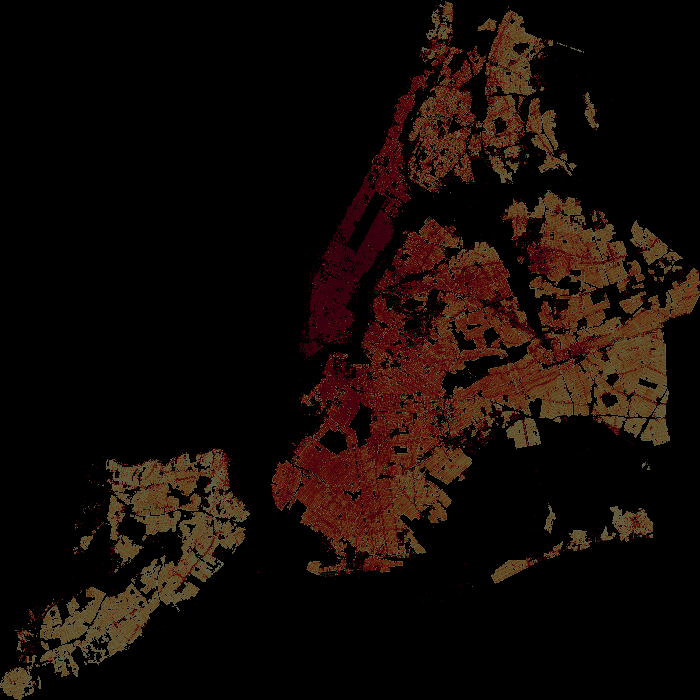

In [99]:
cvs = ds.Canvas(700, 700, *NYC)
agg = cvs.points(ny, 'xcoord', 'ycoord', ds.sum('assessland'))
img2 = tf.shade(agg, cmap = mcm.YlOrRd, how='eq_hist', alpha=100)

export(img2, 'Assessment Land Value')